In [4]:
import json
import networkx as nx
import numpy as np
import gensim
from sklearn.decomposition import TruncatedSVD, NMF
from pymongo.mongo_client import MongoClient
import community
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
model = gensim.models.Doc2Vec.load('../models/doc2vec_22k')
vecs = model.docvecs

In [6]:
print("There are %d document vectors"%len(model.docvecs))

There are 22000 document vectors


In [7]:
collection = MongoClient().arxiv.articles
ai_docs = collection.find({'arxiv_primary_category.term': 'cs.AI'})
ai_vecs = np.array([vecs[doc['id']] for doc in ai_docs])

In [117]:
# # add similars to the database for future ref
# for item in collection.find():
#     similars = model.docvecs.most_similar(positive=[item['id']])
#     collection.update_one({'id': item['id']}, {'$set': {'similars': similars}})

In [84]:
# don't know why this isn't working... gonna do it all in a function
#collection.aggregate([{'$group': 'arxiv_primary_category.term', 'count': { '$sum': 1 } }])

In [8]:
ai_vecs.shape # num of docs by num of features

(165, 300)

In [100]:
# topic_finder = NMF(n_components=3, init='random', random_state=0) # NMF doesn't work because docvecs include negative numbers

In [103]:
topic_finder = TruncatedSVD(n_components=3, algorithm='randomized', random_state=0)

In [106]:
topic_finder.fit_transform(ai_vecs) 

(165, 3)

In [108]:
"""
topic_finder may have gotten rid of some false positives,
but i want to establish a baseline first using simple cosine similarity
to establish a network of papers clustered by their similarity 
"""

'\ntopic_finder may have gotten rid of some false positives,\nbut i want to establish a baseline first using simple cosine similarity\nto establish a network of papers clustered by their similarity \n'

In [23]:
G = nx.Graph()

for ai_doc in collection.find({'arxiv_primary_category.term': 'cs.AI'}):
    for sim in ai_doc['similars']:
        G.add_edge(ai_doc['id'], sim[0], weight=sim[1])

In [34]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0.7]
# esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]
edges = [(u,v) for (u,v,d) in G.edges(data=True)]

In [32]:
pos=nx.spring_layout(G)

/Applications/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


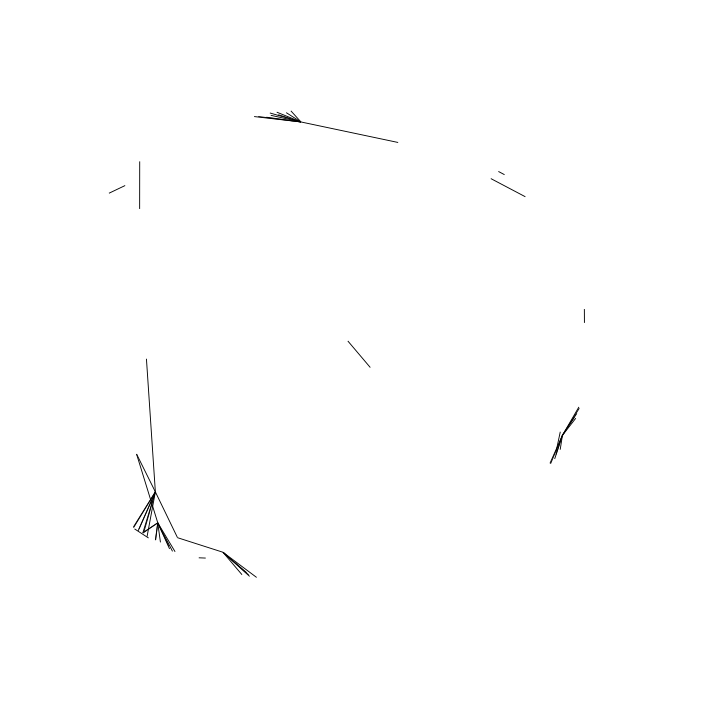

In [35]:
fig = plt.figure(figsize=(12,12))
# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=0.9)
# nx.draw_networkx_edges(G ,pos, edgelist=esmall,width=0.1,alpha=0.5,edge_color='b',style='dashed')

# labels
# nx.draw_networkx_labels(g,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
# plt.savefig("weighted_graph.png") # save as png
plt.show() # display

In [ ]:
partition = community.best_partition(G)

In [50]:
len(set(partition.values()))

49

In [ ]:
# pos = nx.spring_layout(G)

/Applications/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Applications/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


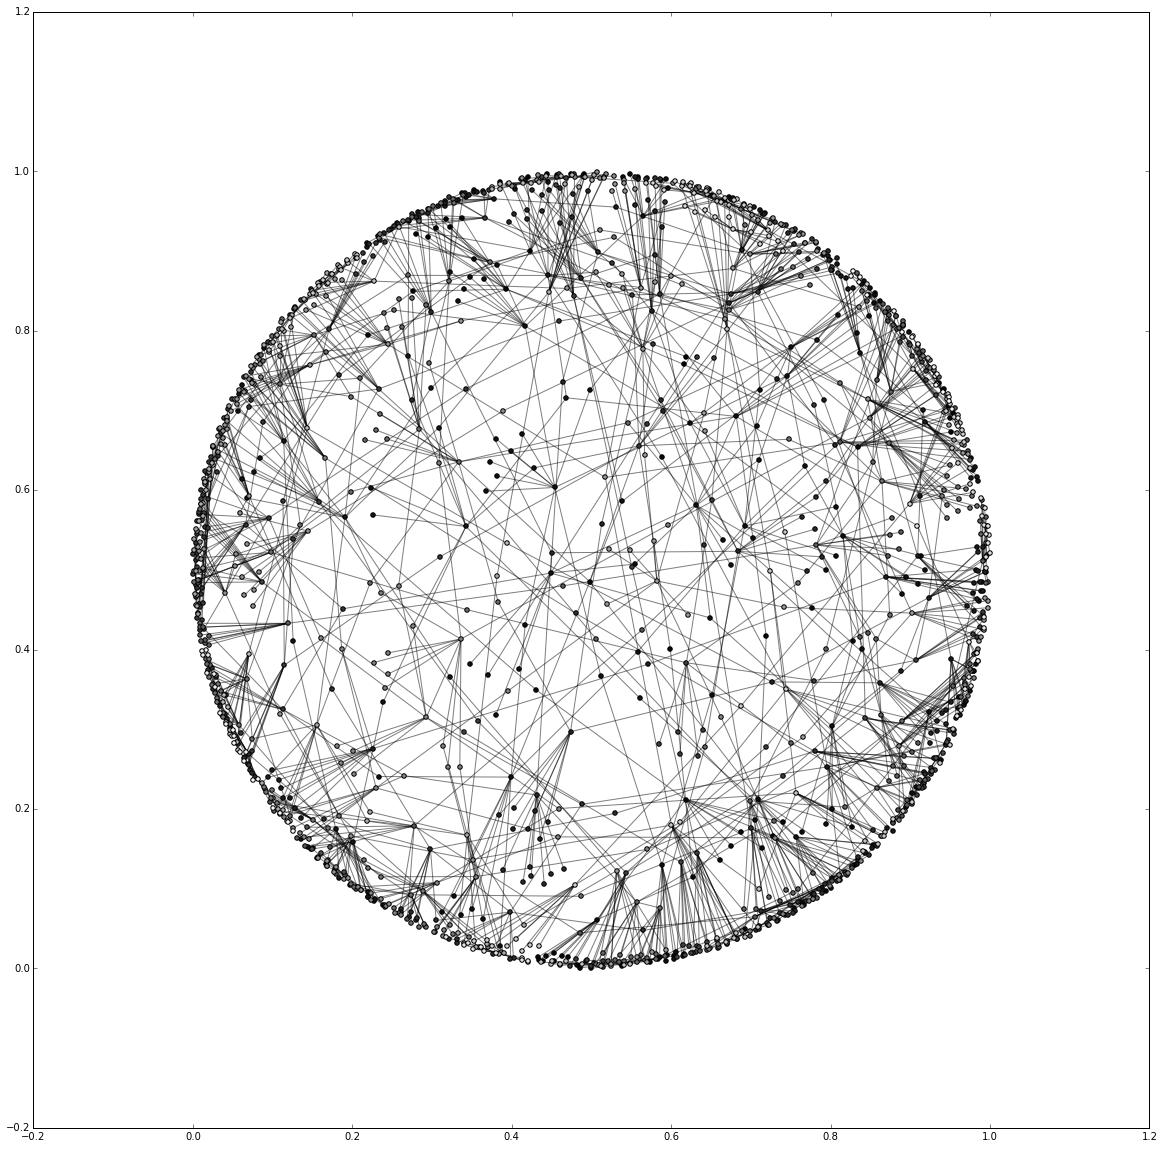

In [42]:
fig = plt.figure(figsize=(20,20))
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

In [39]:
dendro = community.generate_dendogram(G)

In [46]:
len(dendro)

3

In [55]:
len(set(dendro[0].values()))

159

In [57]:
docs = collection.find({'arxiv_primary_category.term': 'cs.AI'})
csv = ''
for doc in docs:
    for similar, weight in doc['similars']:
        csv += doc['id'] + ',' + similar + ',' + str(round(weight, 3)) + '\n'